In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
import seaborn as sns
from ncps.wirings import NCP
import tensorflow as tf
sns.set()

2025-03-05 19:04:48.766066: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 19:04:48.868277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 19:04:49.909602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001

num_samples = [100_000, 20_000, 5_000]

def dpdt(point, params=params): #position

    x,y,z = point
    sig, rho, beta = params
    
    new_x = y*dt*sig + x*(1-dt*sig)
    new_y = x*dt*(rho-z) + y*(1-dt)
    new_z = x*y*dt + z*(1-dt*beta)
    return np.array([new_x, new_y, new_z])

def make_lorenz_rollout(num_samples):
    positions = []
    positions.append(initial_point)

    # your dataset
    for _ in range(num_samples):
        positions.append(dpdt(positions[-1]))

    positions = np.stack(positions)

    labels = np.sum(np.sqrt(np.square(positions[1:num_samples+1] - positions[:num_samples])), axis=1)

    return positions, labels

# Load Models

### NCPS

In [3]:
test_samples = num_samples[1]

In [4]:
out_features = 3
in_features = 3

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=6, command_neurons=5, motor_neurons=out_features,
             sensory_fanout=4, inter_fanout=2, recurrent_command_synapses=4, motor_fanin=2)

num_s = str(test_samples)
PATH = f"models/CFC_state_dict_N{num_s}"

with open(PATH + '/adj_mat.npy', 'rb') as f:
    adj = np.load(f)

with open(PATH + '/sens_mat.npy', 'rb') as f:
    sens = np.load(f)

wiring.adjacency_matrix = adj
wiring.sensory_adjacency_matrix = sens

ncps = CfC(in_features, wiring, batch_first=True, return_sequences=False) # change to cfc, what could go wrong?
ncps.load_state_dict(torch.load(PATH+ "/weights", weights_only=True))




IndexError: index 9 is out of bounds for axis 0 with size 9

### Visualize

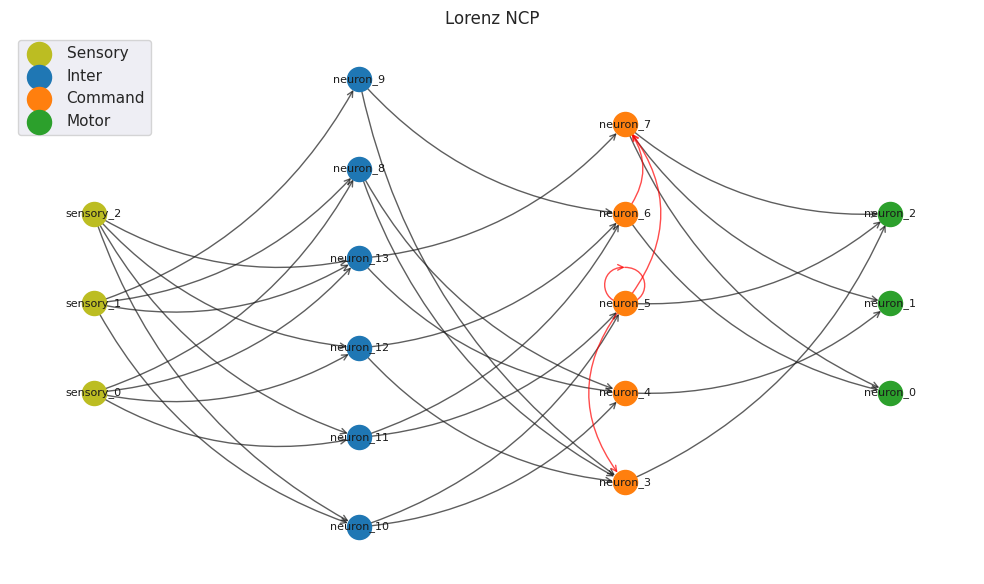

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Obtain the graph from the wiring.
G = wiring.get_graph()

# Separate nodes by type.
sensory_nodes = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "sensory"]
inter_nodes   = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "inter"]
command_nodes = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "command"]
motor_nodes   = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "motor"]

# Assign fixed x-coordinates for a feed-forward layout:
# x = 0 for sensory, 2 for inter, 4 for command, and 6 for motor.
pos = {}
layers = [
    ("sensory", sensory_nodes),
    ("inter", inter_nodes),
    ("command", command_nodes),
    ("motor", motor_nodes)
]
x_spacing = 2.0  # horizontal spacing between layers
y_spacing = 1.0  # vertical spacing within a layer

for layer_index, (layer_name, nodes) in enumerate(layers):
    x = layer_index * x_spacing
    n = len(nodes)
    # Evenly space nodes vertically and center them if there's more than one.
    for i, node in enumerate(sorted(nodes)):
        y = (i - (n - 1) / 2) * y_spacing if n > 1 else 0
        pos[node] = (x, y)

# Separate edges into non-recurrent and recurrent (command -> command) edges.
non_recurrent_edges = []
recurrent_edges = []
for u, v, d in G.edges(data=True):
    # If both source and target are command neurons, mark as recurrent.
    if G.nodes[u]["neuron_type"] == "command" and G.nodes[v]["neuron_type"] == "command":
        recurrent_edges.append((u, v))
    else:
        non_recurrent_edges.append((u, v))

plt.figure(figsize=(10, 6))

# Draw nodes with different colors for each layer.
nx.draw_networkx_nodes(G, pos, nodelist=sensory_nodes, node_color='tab:olive', label='Sensory')
nx.draw_networkx_nodes(G, pos, nodelist=inter_nodes,   node_color='tab:blue',   label='Inter')
nx.draw_networkx_nodes(G, pos, nodelist=command_nodes, node_color='tab:orange', label='Command')
nx.draw_networkx_nodes(G, pos, nodelist=motor_nodes,   node_color='tab:green',  label='Motor')

# Draw non-recurrent edges with a gentle curve.
nx.draw_networkx_edges(
    G, pos,
    edgelist=non_recurrent_edges,
    arrows=True,
    arrowstyle='->',
    connectionstyle='arc3, rad=0.2',  # gentle curve
    alpha=0.7
)

# Draw recurrent edges with a more pronounced curve and a different color.
nx.draw_networkx_edges(
    G, pos,
    edgelist=recurrent_edges,
    arrows=True,
    arrowstyle='->',
    connectionstyle='arc3, rad=0.4',  # increased curvature
    edge_color='red',
    alpha=0.7
)

# Draw node labels.
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.title("Lorenz NCP")
plt.legend()
plt.tight_layout()
plt.show()


### Res

In [7]:
def build_world_model_residual():
    xin_s = tf.keras.layers.Input((3,))

    xs = tf.keras.layers.Dense(32, activation='swish')(xin_s)
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(3)(xs)

    xout = tf.keras.layers.Add()([xs,xin_s])
    return tf.keras.models.Model(xin_s, xout)

build_world_model_residual().summary()

res = build_world_model_residual()
res.compile(loss='mse',optimizer='adam')

PATH = f"models/RESNET_state_dict_N{num_s}.weights.h5"
res.load_weights(PATH)


2025-03-05 00:12:22.155108: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (100)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3)         │          0 │ dense_2[0][0],    │
│                     │                   │            │ input_layer[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,283 (5.01 KB)

 Trainable params: 1,283 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

/home/tristongrayston/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### RNN

In [8]:
class SimpleRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)
        out = out[:, -1, :]
        return out, ht

obs_space_size = 3
action_space_size = 0
hidden_size = 16
rnn = SimpleRNN(obs_space_size, action_space_size, hidden_size)

num_s = str(test_samples)
PATH = f"models/RNN_state_dict_N{num_s}"
rnn.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

# Liquid

In [9]:
liquid = LTC(in_features, out_features, batch_first=True, return_sequences=False)
PATH = f"models/LTC_N{num_s}"
liquid.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

# Cool Graphs

In [12]:
test_samples = num_samples[2]
positions, _ = make_lorenz_rollout(test_samples)

print(positions.shape)

p_max = np.max(positions)
p_min = np.min(positions)

# Add noise
#positions = positions+np.random.randn(test_samples + 1,3) * 0.1

# Scale
positions = positions/p_max # (normalize to between 1 some negative number that won't be 1) 

x = []
y = []
traj_len = 5
for i in range(test_samples - traj_len):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+1])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

t_inputs = torch.FloatTensor(data_x)
print(t_inputs.shape)


(5001, 3)
torch.Size([4995, 5, 3])


In [13]:
# now we have to make them into batches of sequence lengths

with torch.no_grad():
    rnn_pred = rnn.forward(t_inputs)[0].numpy()
    ncps_pred = ncps(t_inputs)[0].numpy()

res_pred = np.array(res.predict(positions[0:-1]))
res_pred.shape

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


(5000, 3)

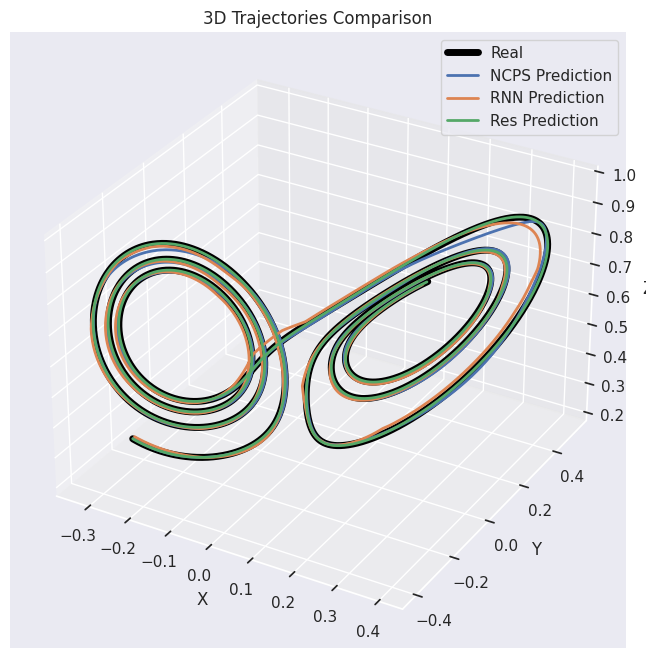

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import torch

# Example data
# t_inputs = torch.FloatTensor(inputs).unsqueeze(0)
# with torch.no_grad():
#     liq_pred = liquid(t_inputs)[0].numpy()
#     rnn_pred = rnn.forward(t_inputs)[0].numpy()
# res_pred = np.array(res.predict(inputs))

# For demonstration, assume these are each [T, 3] arrays:
# liq_pred, rnn_pred, res_pred, inputs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the real data (inputs) as a thick line with no transparency
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], linewidth=5, alpha=1.0, label='Real', color='black')

# Plot predicted trajectories with thinner lines and partial transparency
ax.plot(ncps_pred[:, 0], ncps_pred[:, 1], ncps_pred[:, 2],
         linewidth=2, alpha=1, label='NCPS Prediction')
ax.plot(rnn_pred[:, 0], rnn_pred[:, 1], rnn_pred[:, 2],
        linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_pred[:, 0], res_pred[:, 1], res_pred[:, 2],
         linewidth=2, alpha=1, label='Res Prediction')

# Create small shaded polygons connecting each real point to the corresponding
# predicted points. This can be visually heavy if T is large, so consider
# downsampling if needed.


# Label the axes and set a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectories Comparison')

ax.legend()
plt.show()


In [15]:
test_samples = num_samples[2]
initial_point = np.array([-0.510, -0.4218712, -0.23523])
dt = 0.003
positions, _ = make_lorenz_rollout(test_samples)

print(positions.shape)

p_max = np.max(positions)
p_min = np.min(positions)

# Add noise
positions = positions+np.random.randn(test_samples + 1,3) * 0.1

# Scale
positions = positions/p_max # (normalize to between 1 some negative number that won't be 1) 

x = []
y = []
traj_len = 5
for i in range(test_samples - traj_len):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+1])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

inputs = positions[0:-1]
t_inputs = torch.FloatTensor(data_x)
print(t_inputs.shape)
print(inputs.shape)

# now we have to make them into batches of sequence lengths

with torch.no_grad():
    liq_pred = liquid(t_inputs)[0].numpy()
    ncps_pred = liquid(t_inputs)[0].numpy()
    rnn_pred = rnn.forward(t_inputs)[0].numpy()

res_pred = np.array(res.predict(inputs))
res_pred.shape

(5001, 3)
torch.Size([4995, 5, 3])
(5000, 3)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


(5000, 3)

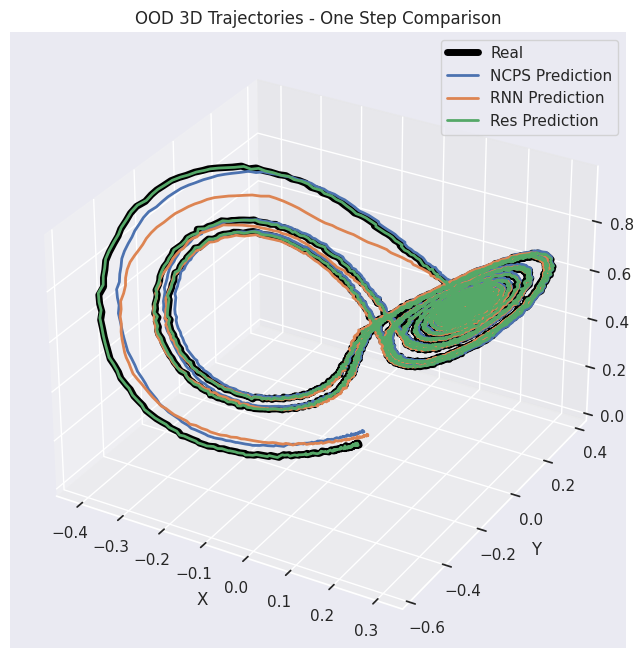

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import torch

# Example data
# t_inputs = torch.FloatTensor(inputs).unsqueeze(0)
# with torch.no_grad():
#     liq_pred = liquid(t_inputs)[0].numpy()
#     rnn_pred = rnn.forward(t_inputs)[0].numpy()
# res_pred = np.array(res.predict(inputs))

# For demonstration, assume these are each [T, 3] arrays:
# liq_pred, rnn_pred, res_pred, inputs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the real data (inputs) as a thick line with no transparency
ax.plot(inputs[:, 0], inputs[:, 1], inputs[:, 2],
     linewidth=5, alpha=1.0, label='Real', color='black')

# Plot predicted trajectories with thinner lines and partial transparency
ax.plot(ncps_pred[:, 0], ncps_pred[:, 1], ncps_pred[:, 2],
         linewidth=2, alpha=1, label='NCPS Prediction')
#ax.plot(liq_pred[:, 0], liq_pred[:, 1], liq_pred[:, 2],
#        linewidth=2, alpha=1, label='Liquid Prediction')
ax.plot(rnn_pred[:, 0], rnn_pred[:, 1], rnn_pred[:, 2],
   linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_pred[:, 0], res_pred[:, 1], res_pred[:, 2],
      linewidth=2, alpha=1, label='Res Prediction')

# Create small shaded polygons connecting each real point to the corresponding
# predicted points. This can be visually heavy if T is large, so consider
# downsampling if needed.

# Label the axes and set a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('OOD 3D Trajectories - One Step Comparison')

ax.legend()
plt.show()


# Multi-Step Rollouts

In [36]:
l_rolling_inputs = r_rolling_inputs = n_rolling_inputs = t_inputs[0]
print(t_inputs[0])
window = inputs.shape[1]

r_rolling_inputs = r_rolling_inputs.unsqueeze(axis=0)

#print(r_rolling_inputs.shape)

liquid_predictions = []
rnn_predictions = []
ncps_predictions = []

num_predictions = 10_000

for i in range(num_predictions):
    with torch.no_grad():
        l_prediction = liquid(l_rolling_inputs)[0].unsqueeze(0)
        r_prediction = rnn(r_rolling_inputs)[0].unsqueeze(0)
        n_prediction = ncps(n_rolling_inputs)[0].unsqueeze(0)


    liquid_predictions.append(l_prediction)
    rnn_predictions.append(r_prediction)
    ncps_predictions.append(n_prediction)
    
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(r_prediction.shape)
    #print(r_rolling_inputs.shape)
    
    l_rolling_inputs = torch.concatenate((l_rolling_inputs[1:window+1], l_prediction))
    r_rolling_inputs = torch.concatenate((r_rolling_inputs[:, 1:window+1, :], r_prediction), axis=1)
    n_rolling_inputs = torch.concatenate((n_rolling_inputs[1:window+1], n_prediction))


    print(n_rolling_inputs, " ", prediction)


#predictions.shape


tensor([[-0.0094, -0.0079, -0.0057],
        [-0.0091, -0.0088, -0.0036],
        [-0.0098, -0.0116, -0.0054],
        [-0.0083, -0.0125, -0.0031],
        [-0.0066, -0.0091, -0.0050]])


NameError: name 'predictions' is not defined

In [37]:
liquid_predictions = torch.stack(liquid_predictions).squeeze(1).numpy()
rnn_predictions = torch.stack(rnn_predictions).squeeze(1).numpy()
ncps_predictions = torch.stack(ncps_predictions).squeeze(1).numpy()
liquid_predictions.shape

(10000, 3)

In [38]:
liquid_predictions.shape
rnn_predictions.shape
ncps_predictions.shape

(10000, 3)

In [39]:
liquid_predictions[2, :]

array([0.02038493, 0.00036642, 0.10462749], dtype=float32)

In [40]:
start = inputs[3:4, :]
start

array([[-0.00834228, -0.01252653, -0.00309817]])

In [41]:
res_prediction = []
#start = res(t_inputs[0, -1, :].unsqueeze(0).numpy())
print(start)
res_prediction.append(np.array(res(start)))
for i in range(num_predictions-1):
    # random action
    _state = np.array(res(res_prediction[-1]))
    #print(_state.shape)
    # pend length
    res_prediction.append(_state)

[[-0.00834228 -0.01252653 -0.00309817]]


In [42]:
res_prediction = np.stack(res_prediction)
res_prediction.shape

(10000, 1, 3)

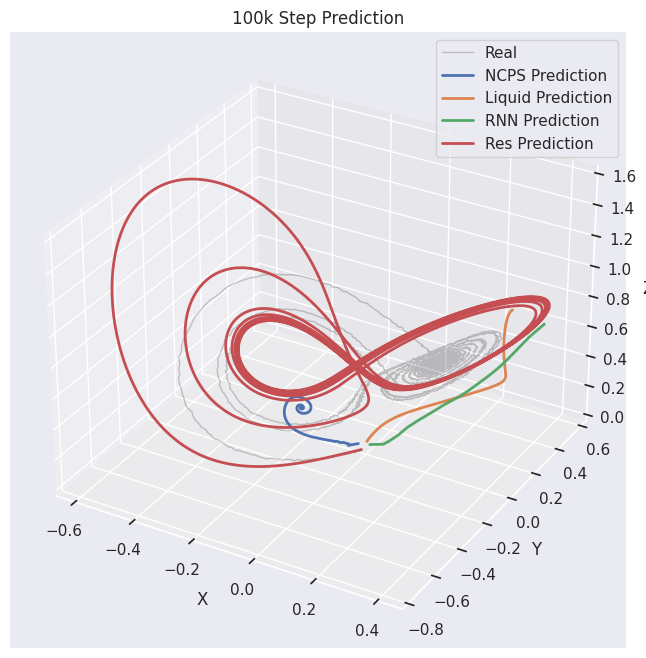

In [43]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the real data (inputs) as a thick line with no transparency
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
     linewidth=1, alpha=0.2, label='Real', color='black')

#Plot predicted trajectories with thinner lines and partial transparency
ax.plot(ncps_predictions[:, 0], ncps_predictions[:, 1], ncps_predictions[:, 2],
        linewidth=2, alpha=1, label='NCPS Prediction')
ax.plot(liquid_predictions[:, 0], liquid_predictions[:, 1], liquid_predictions[:, 2],
        linewidth=2, alpha=1, label='Liquid Prediction')
ax.plot(rnn_predictions[:,0, 0], rnn_predictions[:, 0, 1], rnn_predictions[:,0, 2],
   linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_prediction[:, 0, 0], res_prediction[:, 0, 1], res_prediction[:, 0, 2],
      linewidth=2, alpha=1, label='Res Prediction')

# Create small shaded polygons connecting each real point to the corresponding
# predicted points. This can be visually heavy if T is large, so consider
# downsampling if needed.

# Label the axes and set a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('100k Step Prediction')

ax.legend()
plt.show()


# Decoherence

In [1]:
# We set an arbitrary X, an upper bound for max euclidean distance 
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001

positions, labels = make_lorenz_rollout(test_samples)
positions /= np.max(positions)
labels /= np.max(positions)
X = np.max(labels) + 1/4 * np.max(labels)
X

NameError: name 'np' is not defined

In [45]:
np.random.seed(101)
start_positions = np.random.randint(5, test_samples - 100, size=50)

In [46]:


# for residuals
test_positions_rec = []
real_positions = []
for i in range(5):
    test_positions_rec.append(positions[start_positions-5+i, :])

for i in range(100):
    real_positions.append(positions[start_positions+i, :])
    
test_positions_rec = np.stack(test_positions_rec)
real_positions = np.stack(real_positions).swapaxes(0, 1)
print(real_positions.shape)

test_positions_residual = test_positions_rec[-1, :, :]
test_positions_rec = test_positions_rec.swapaxes(0, 1)
test_positions_rec.shape

#print(test_positions_rec[0, :, :], real_positions[0, 0, :])
#print(positions[start_positions[0]])


(50, 100, 3)


(50, 5, 3)

In [48]:
l_rolling_inputs = r_rolling_inputs = n_rolling_inputs = torch.FloatTensor(test_positions_rec)
window = inputs.shape[1]

#print(r_rolling_inputs.shape)

liquid_predictions = []
rnn_predictions = []
ncps_predictions = []

num_predictions = 100

for i in range(num_predictions):
    with torch.no_grad():
        l_prediction = liquid(l_rolling_inputs)[0].unsqueeze(0).swapaxes(0, 1)
        r_prediction = rnn(r_rolling_inputs)[0].unsqueeze(0).swapaxes(0, 1)
        n_prediction = ncps(n_rolling_inputs)[0].unsqueeze(0).swapaxes(0, 1)


    #print(l_prediction.shape, " ", r_prediction.shape)
    liquid_predictions.append(l_prediction)
    rnn_predictions.append(r_prediction)
    ncps_predictions.append(n_prediction)
    #print(l_rolling_inputs.shape, " ", r_rolling_inputs.shape)
    
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(r_prediction.shape)
    #print(r_rolling_inputs.shape)

    l_rolling_inputs = torch.concatenate((l_rolling_inputs[:, 1:window+2, :], l_prediction), axis=1)
    r_rolling_inputs = torch.concatenate((r_rolling_inputs[:, 1:window+2, :], r_prediction), axis=1)
    n_rolling_inputs = torch.concatenate((n_rolling_inputs[:, 1:window+2, :], n_prediction), axis=1)


    #print(rolling_inputs, " ", prediction)


In [49]:
liquid_predictions = torch.stack(liquid_predictions).squeeze(2).numpy().swapaxes(0, 1)
rnn_predictions = torch.stack(rnn_predictions).squeeze(2).numpy().swapaxes(0, 1)
ncps_predictions = torch.stack(ncps_predictions).squeeze(2).numpy().swapaxes(0, 1)
liquid_predictions.shape

(50, 100, 3)

In [50]:
liquid_res = liquid_predictions - real_positions
liquid_predictions
print(liquid_predictions[0, 0, :], real_positions[0, 0, :] , liquid_res[0, 0, :])
liquid_res_summed = np.sum(np.abs(liquid_res[0]), axis=-1)
liquid_res_summed

[ 0.868956   -0.00706097  1.5212688 ] [ 2.63560141 -0.73373225 26.1322206 ] [ -1.76664538   0.72667128 -24.61095176]


array([27.10426841, 27.38529186, 27.47951757, 27.5040777 , 27.49353677,
       27.46248394, 27.4176907 , 27.36337352, 27.30209434, 27.23554058,
       27.16487916, 27.09094615, 27.01436122, 26.93559562, 26.85501453,
       26.77290852, 26.68951085, 26.60501302, 26.51957445, 26.43332937,
       26.34639214, 26.25886223, 26.17082638, 26.08236123, 25.99353559,
       25.90441084, 25.81504334, 25.72548413, 25.6357803 , 25.54597543,
       25.45610977, 25.36622114, 25.27634371, 25.18651041, 25.09675147,
       25.00709495, 24.91756753, 24.82819318, 24.73899485, 24.64999426,
       24.56121021, 24.47266145, 24.38436426, 24.29633381, 24.20858446,
       24.1211291 , 24.0339794 , 23.94714627, 23.86063938, 23.77446707,
       23.6886376 , 23.60315785, 23.51803402, 23.43327202, 23.34887633,
       23.26485143, 23.18120074, 23.09792758, 23.01503464, 22.93252393,
       22.85039778, 22.7686569 , 22.68730258, 22.60633525, 22.5257554 ,
       22.44556331, 22.36575876, 22.28634169, 22.20731106, 22.12

In [51]:
liquid_res = np.sum(np.sqrt(np.square(liquid_predictions - real_positions)), axis=-1)
rnn_res = np.sum(np.sqrt(np.square(rnn_predictions - real_positions)), axis=-1)
ncps_res = np.sum(np.sqrt(np.square(ncps_predictions - real_positions)), axis=-1)

In [52]:
liquid_res

array([[27.10426841, 27.38529186, 27.47951757, ..., 20.07649909,
        20.0082511 , 19.94032732],
       [58.90791566, 59.11832715, 59.17176016, ..., 39.74612441,
        39.62636788, 39.50578476],
       [57.63436355, 57.99598302, 58.20078262, ..., 47.10470129,
        46.91698662, 46.72938384],
       ...,
       [27.99330113, 28.34172886, 28.52686364, ..., 31.12346651,
        31.16861709, 31.21419632],
       [26.62754738, 26.88096111, 26.98157504, ..., 21.78575721,
        21.73749091, 21.6895229 ],
       [34.51366925, 34.77055943, 34.86400782, ..., 29.58423551,
        29.54601363, 29.50803736]])

In [53]:
liquid_res.shape

(50, 100)

In [56]:
liquid_mask = (liquid_res > X)
res_mask = (ncps_res > X)

In [57]:
res_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
